The Model Creation, training and inference, everything is part of the same ipynb file.

if running locally update the path variables to the actual values.

## Import TensorFlow and other libraries

In [68]:
import tensorflow as tf
import keras
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import pathlib
import time
import datetime

from IPython import display
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Flatten, BatchNormalization, LeakyReLU
from keras.layers import Conv2DTranspose, Dropout, ReLU, Input, Concatenate, ZeroPadding2D
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.losses import BinaryCrossentropy
from keras import backend
from keras.callbacks import ModelCheckpoint

## Set Global variable values

In [192]:
BUFFER_SIZE = 400
BATCH_SIZE = 10
IMAGE_HEIGHT = 100
IMAGE_WIDTH = 100
CHANNELS = 3
IMAGE_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH , CHANNELS)
PATCH_HEIGHT = 128
PATCH_WIDTH = 128
INPUT_SHAPE = (PATCH_HEIGHT, PATCH_WIDTH, CHANNELS)
LAMBDA = 100

## Define all util methods

In [70]:
def load_single_file(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)
  # Convert image to float32 tensors
  image = tf.cast(image, tf.float32)
  return image

In [71]:
def load(input_image_file, target_image_file):
  input_image = load_single_file(input_image_file)
  target_image = load_single_file(target_image_file)
  return input_image, target_image

In [72]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [73]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) -1

  return input_image, real_image

In [74]:
def load_image(input_image_file, target_image_file):
  input_image, target_image = load(input_image_file, target_image_file)
  input_image, target_image = resize(input_image, target_image,
                                   PATCH_HEIGHT, PATCH_WIDTH)
  input_image, target_image = normalize(input_image, target_image)

  return input_image, target_image

In [75]:
def load_image_inference(input_image_file):
  input_image = load_single_file(input_image_file)
  input_image = tf.image.resize(input_image, [PATCH_HEIGHT, PATCH_WIDTH],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  input_image = (input_image / 127.5) - 1

  return input_image

In [210]:
def load_dataset(is_training=True):
  if is_training==True:
    input_ = train_input_images_path
    target_ = train_target_images_path
  else:
    input_ = test_input_images_path
    target_ = test_target_images_path

  input_filenames = sorted(os.listdir(input_))
  target_filenames = sorted(os.listdir(target_))

  # Create a list of file pairs
  file_pairs = [(os.path.join(input_, source), os.path.join(target_, target))
                for source, target in zip(input_filenames, target_filenames)]
  # Create a tf.data.Dataset from the list of file pairs
  dataset = tf.data.Dataset.from_tensor_slices(file_pairs)

  # Map the dataset to load and preprocess images
  dataset = dataset.map(lambda input_target: load_image(input_target[0], input_target[1]))

  # Optionally shuffle and batch the dataset
  dataset = dataset.shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE)

  # Print the first few elements of the dataset
  for source, target in dataset.take(5):
      print("Source Shape:", source.shape, "Target Shape:", target.shape)
  return dataset.take(100)

In [170]:
def show_images(input, target):
  plt.figure(figsize=(6, 6))

  display_list = [input[0], target[0]]
  title = ['Input Image', 'Target Image']
  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

Define the downsampler (encoder):

In [171]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

Define the upsampler (decoder):

In [172]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

Define the generator with the downsampler and the upsampler:

## Build the generator

The generator of your pix2pix cGAN is a _modified_ [U-Net](https://arxiv.org/abs/1505.04597){:.external}. A U-Net consists of an encoder (downsampler) and decoder (upsampler).

- Each block in the encoder is: Convolution -> Batch normalization -> Leaky ReLU
- Each block in the decoder is: Transposed convolution -> Batch normalization -> Dropout (applied to the first 3 blocks) -> ReLU
- There are skip connections between the encoder and decoder (as in the U-Net).

In [173]:
def Generator():
  inputs = tf.keras.layers.Input(shape=INPUT_SHAPE)

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),
    downsample(128, 4),
    downsample(256, 4),
    downsample(512, 4),
    downsample(512, 4),
    downsample(512, 4),
    downsample(512, 4),
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),
    upsample(512, 4, apply_dropout=True),
    upsample(512, 4, apply_dropout=True),
    upsample(512, 4),
    upsample(256, 4),
    upsample(128, 4),
    upsample(64, 4),
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Visualize the generator model architecture:

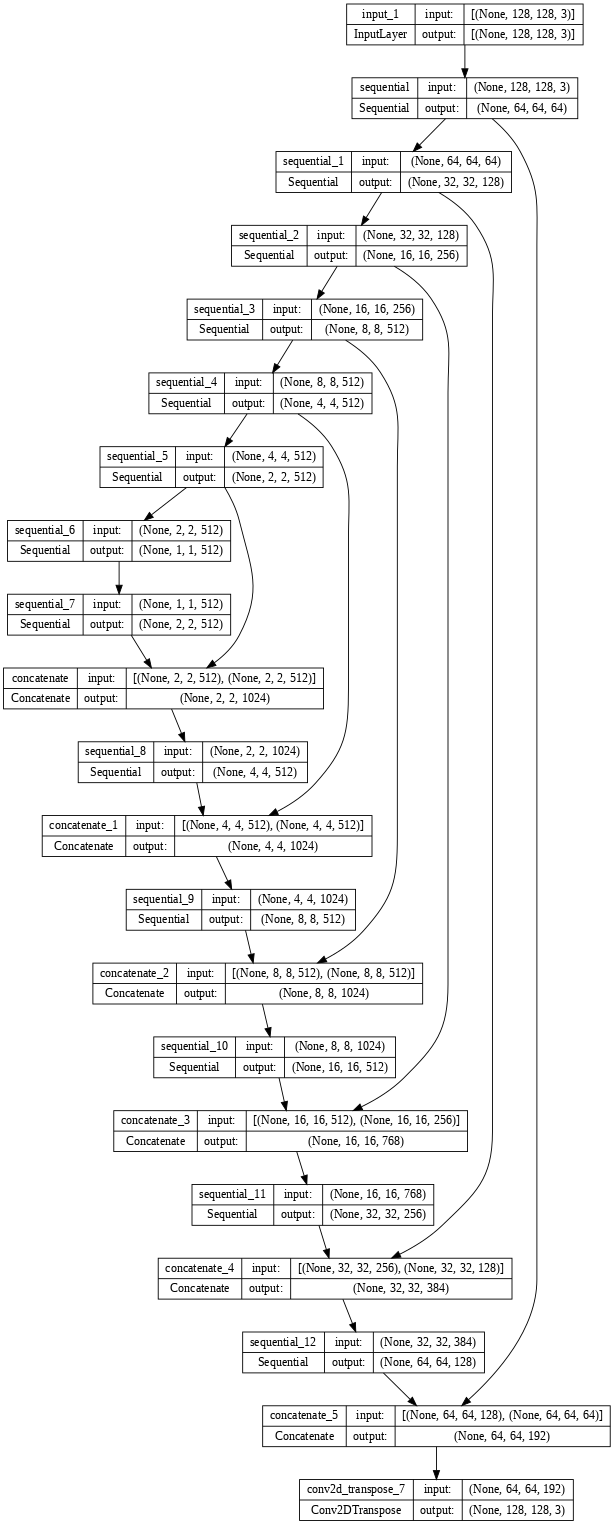

In [211]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

### Define the generator loss

GANs learn a loss that adapts to the data, while cGANs learn a structured loss that penalizes a possible structure that differs from the network output and the target image, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004){:.external}.

- The generator loss is a sigmoid cross-entropy loss of the generated images and an **array of ones**.
- The pix2pix paper also mentions the L1 loss, which is a MAE (mean absolute error) between the generated image and the target image.
- This allows the generated image to become structurally similar to the target image.
- The formula to calculate the total generator loss is `gan_loss + LAMBDA * l1_loss`, where `LAMBDA = 100`. This value was decided by the authors of the paper.

In [195]:
def generator_loss(disc_generated_output, gen_output, target):

  loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss

## Build the discriminator

The discriminator in the pix2pix cGAN is a convolutional PatchGAN classifier—it tries to classify if each image _patch_ is real or not real, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004){:.external}.

- Each block in the discriminator is: Convolution -> Batch normalization -> Leaky ReLU.
- The shape of the output after the last layer is `(batch_size, 30, 30, 1)`.
- Each `30 x 30` image patch of the output classifies a `70 x 70` portion of the input image.
- The discriminator receives 2 inputs:
    - The input image and the target image, which it should classify as real.
    - The input image and the generated image (the output of the generator), which it should classify as fake.
    - Use `tf.concat([inp, tar], axis=-1)` to concatenate these 2 inputs together.

In [176]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[128, 128, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[128, 128, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])

  down1 = downsample(64, 4, False)(x)
  down2 = downsample(128, 4)(down1)
  down3 = downsample(256, 4)(down2)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

Visualize the discriminator model architecture:

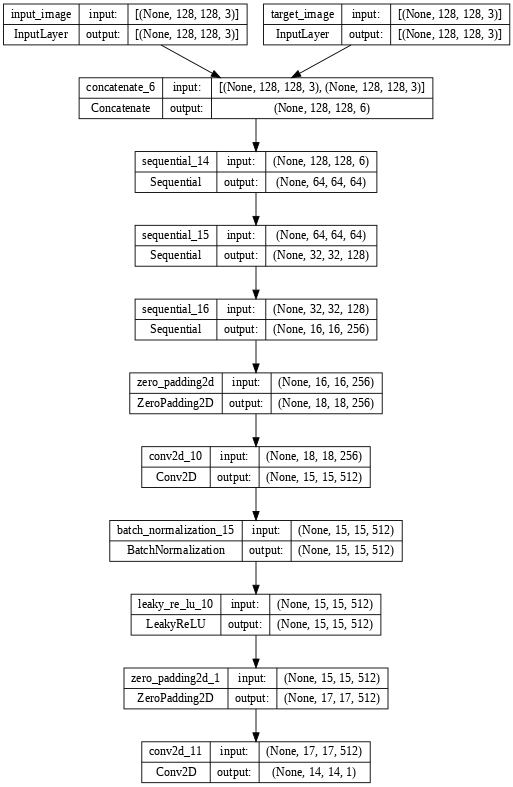

In [212]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

### Define the discriminator loss

- The `discriminator_loss` function takes 2 inputs: **real images** and **generated images**.
- `real_loss` is a sigmoid cross-entropy loss of the **real images** and an **array of ones(since these are the real images)**.
- `generated_loss` is a sigmoid cross-entropy loss of the **generated images** and an **array of zeros (since these are the fake images)**.
- The `total_loss` is the sum of `real_loss` and `generated_loss`.

In [197]:
def discriminator_loss(disc_real_output, disc_generated_output):

  loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

## Overall architecture

![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


In [213]:
generator_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)

## Load the dataset

Download the DPED dataset from the url https://people.ee.ethz.ch/~ihnatova/
or Dowload separately and upload to your drive use by mounting google drive
Then mount the drive

In [87]:
_URL = "http://data.vision.ee.ethz.ch/ihnatova/public/dped/dped.gz"

path_to_zip = tf.keras.utils.get_file(
    fname="dped.gz",
    origin=_URL,
    extract=True)

path_to_zip  = pathlib.Path(path_to_zip)

PATH = path_to_zip.parent/"dped"

6605953079/6605953079 [==============================] - 139s 0us/step


10 mins to download the dataset

change camera_model to "iphone" or "sony" if we want to train on those datasets


In [214]:
camera_model = "blackberry"
dslr_camera_name = "canon"

training_path = os.path.join(PATH / camera_model, "training_data")
train_input_images_path = os.path.join(training_path, camera_model)
train_target_images_path = os.path.join(training_path, dslr_camera_name)

train_input_images_path = pathlib.Path(train_input_images_path)
train_target_images_path = pathlib.Path(train_target_images_path)


testing_path = os.path.join(PATH / camera_model, "test_data/patches")
test_input_images_path = os.path.join(testing_path, camera_model)
test_target_images_path = os.path.join(testing_path, dslr_camera_name)

test_input_images_path = pathlib.Path(test_input_images_path)
test_target_images_path = pathlib.Path(test_target_images_path)

In [215]:
train_dataset = load_dataset(True)

Source Shape: (10, 128, 128, 3) Target Shape: (10, 128, 128, 3)
Source Shape: (10, 128, 128, 3) Target Shape: (10, 128, 128, 3)
Source Shape: (10, 128, 128, 3) Target Shape: (10, 128, 128, 3)
Source Shape: (10, 128, 128, 3) Target Shape: (10, 128, 128, 3)
Source Shape: (10, 128, 128, 3) Target Shape: (10, 128, 128, 3)


In [216]:
test_dataset = load_dataset(False)

Source Shape: (10, 128, 128, 3) Target Shape: (10, 128, 128, 3)
Source Shape: (10, 128, 128, 3) Target Shape: (10, 128, 128, 3)
Source Shape: (10, 128, 128, 3) Target Shape: (10, 128, 128, 3)
Source Shape: (10, 128, 128, 3) Target Shape: (10, 128, 128, 3)
Source Shape: (10, 128, 128, 3) Target Shape: (10, 128, 128, 3)


In [217]:
len(train_dataset), len(test_dataset)

(100, 100)

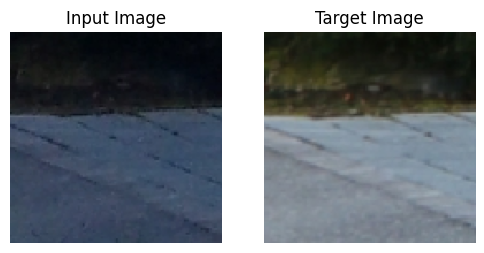

In [184]:
for input_, target_ in train_dataset.take(1):
  show_images(input_, target_)

## Mount the drive, create folders and checkpoints


In [134]:
from google.colab import drive
# Mount Google Drive to Colab
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [135]:
main_project_folder = '/content/drive/MyDrive/TPA9/'
model_checkpoint_folder = '/content/drive/MyDrive/TPA9/ModelCheckpoint/'
images_collection_folder = '/content/drive/MyDrive/TPA9/ImageCollection/'
trained_model_folder = '/content/drive/MyDrive/TPA9/TrainedModels'

In [136]:
!mkdir {main_project_folder}
!mkdir {model_checkpoint_folder}
!mkdir {images_collection_folder}
!mkdir {trained_model_folder}

mkdir: cannot create directory ‘/content/drive/MyDrive/TPA9/’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/TPA9/ModelCheckpoint/’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/TPA9/ImageCollection/’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/TPA9/TrainedModels’: File exists


In [137]:
checkpoint_prefix = os.path.join(model_checkpoint_folder, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generate images

Write a function to plot some images during training.

- Pass images from the test set to the generator.
- The generator will then translate the input image into the output.
- The last step is to plot the predictions and _voila_!

In [203]:
count = 0
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']
  global count
  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.savefig(f"{images_collection_folder}/generated_image_epoch_{count}.jpg")
  count+=1
  plt.show()

Test the function:

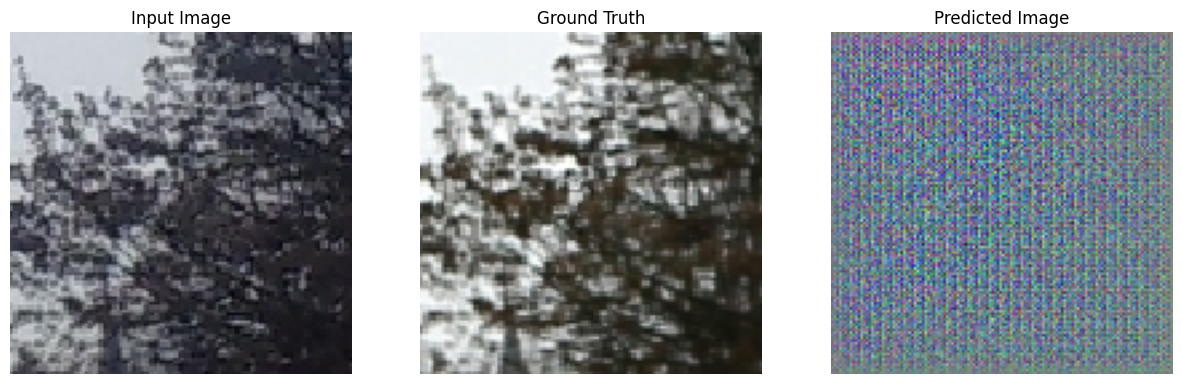

In [204]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

## Training

- For each example input generates an output.
- The discriminator receives the `input_image` and the generated image as the first input. The second input is the `input_image` and the `target_image`.
- Next, calculate the generator and the discriminator loss.
- Then, calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.


In [218]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
    return gen_total_loss, disc_loss

In [219]:
def fit_with_epoch(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()

        for input_, target in test_ds.take(1):
            generate_images(generator, input_, target)
        # Train
        print(f"Epoch {epoch}")
        for n, (input_, target) in train_ds.enumerate():
            gen_loss, disc_loss = train_step(input_, target, epoch)
            if (n%100 == 0):
              print(".", end= "", flush=True)
        print("Generator loss {:.2f} Discriminator loss {:.2f}".format(gen_loss, disc_loss))
        print("Time take for epoch {} is {} sec\n".format(epoch+1, time.time() - start))

The actual training loop. the datasets vary greatly in size the training loop is setup to work in steps instead of epochs.

- Iterates over the number of steps.
- Every 10 steps print a dot (`.`).
- Every 1k steps: clear the display and run `generate_images` to show the progress.
- Every 5k steps: save a checkpoint.

In [143]:
def fit_with_steps(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

Finally, run the training loop:

the model after 7k steps shows better results


<h1>SKIP THIS IF NOT TRAINING

In [220]:
keras.backend.clear_session()

In [ ]:
fit_with_epoch(train_dataset, 100, test_dataset)

In [ ]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(1):
  generate_images(generator, inp, tar)

In [ ]:
generator.save(f"{trained_model_folder}/generator_epoch_final.h5")

## <H1>Testing</H1>Restore the latest checkpoint and test the network

In [ ]:

generator = tf.keras.models.load_model(f"{trained_model_folder}/generator_epoch_final.h5")

## Generate some images using the test set

In [ ]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)